#### 03. 정밀도와 재현율
- 재현율 = TP / (FN + TP), 정밀도 = TP / (FP + TP)
- 재현율과 정밀도 모두 TP를 높이고자 함은 공통적이지만 재현율은 FN을 낮추는 것, 정밀도는 FP를 낮추는데 초점을 맞춘다.

- 오차 행렬 및 정밀도, 재현율을 모두 구해서 예측 성능 평가

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion= confusion_matrix(y_test, pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test, pred)
    recall=recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피쳐 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin']=df['Cabin'].str[:1]
    features=['Cabin','Sex','Embarked']
    for feature in features:
        le=LabelEncoder()
        le=le.fit(df[feature])
        df[feature]=le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호줄
def transform_features(df):
    df=fillna(df)
    df=drop_features(df)
    df=format_features(df)
    return df

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df=pd.read_csv('../DATA/titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived', axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf=LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


- 정밀도/재현율 트레이드오프

In [10]:
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba()결과 shape : {0}',format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값으 한눈에 확인
pred_proba_result=np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 shape : {0} (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935225 0.55064775]
 [0.86335511 0.13664489]
 [0.86429643 0.13570357]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935225 0.55064775 1.        ]
 [0.86335511 0.13664489 0.        ]
 [0.86429643 0.13570357 0.        ]]


- threshold 변수를 특정 값으로 설정하고 Binarizer 클래스를 객체로 생성

In [4]:
from sklearn.preprocessing import Binarizer

X=[[1,-1,2],
   [2,0,0],
   [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer=Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [5]:
# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold=0.5

# predict_proba() 반환값의 두 번째 컬럼, 즉 Positive 클래스 컬럼 하나만 추출해 Binarizer를 적ㄱ용
pred_proba_1=pred_proba[:,1].reshape(-1,1)

binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [6]:
# Binarizer의 threshold 설정값dmf 0.4로 설정. 즉 분류 결정 임곗값을 0.5 => 0.4
custom_threshold=0.4
pred_proba_1=pred_proba[:,1].reshape(-1,1)
binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


- 임곗값을 낮추니 재현율 값이 올라가고 정밀도는 떨어졌다

In [7]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds=[0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iterarion하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict=binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


- 임곗값 데이터 147건 중 10건만 샘플로 추출
- 임곗값을 15 단계로 추출하여 좀 더 큰 값의 임곗값과 그때의 정밀도와 재현율 값 살펴보기

In [8]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 떄의 예측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 갑이 1일 떄의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds=precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출
thr_index=np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도:  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


- 정밀도와 재현율 곡선을 시각화

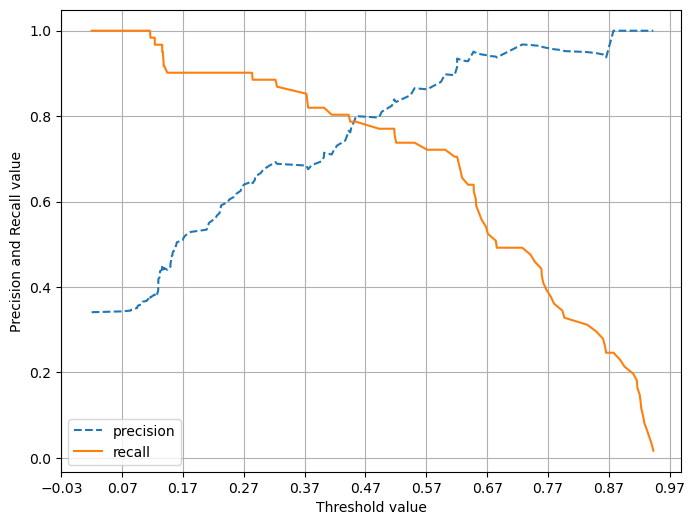

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds=precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary=thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

- 임곗값이 약 0.45 지점에서 재현율과 정밀도가 비슷해지는 모습 확인

#### 정밀도와 재현율의 맹점
[1] 정밀도 100% 달성 방법
- 확실한 기준이 되는 경우만 Positive로 예측하고 나머지는 모두 Negative로 예측
- 예: 환자가 80세 이상이고 비만이며 이전에 암 진단을 받아고 암 세포의 크기가 상위 0.1% 이상이면 무조건 posiive, 나머지는 Negative

[2] 재현율 100% 달성 방법
- 모든 환자를 positive로 예측. 재현율 = TP / (TP + FN)이므로 전체환자 1000명을 모두 Positive로 예측
- 실제 양성인 사람이 30명 ㅈ정도라도 TN이 수치에 포함되지 않고 FN은 0이므로 30 / (30+0)으로 100% 달성

> 정밀도와 재현율 성능 수치도 어느 한 쪽만 참조하면 극단적인 수치 조작이 가능하다.
따라서 정밀도 또는 재현율 중 하나만 스코어가 좋고 다른 하나는 스코어가 나쁜 분류는 성능이 좋지 않은 분류로 간주할 수 있다.